to aquire af lep b nircam coron data:

1st epoch: jwst_download.py -v --instrument nircam --propID 4558 -f uncal.fits --date_select 2023-10-11 2023-10-14

2nd epoch: jwst_download.py -v --instrument nircam --propID 4558 -f uncal.fits --date_select 2023-11-01 2023-11-03

3rd epoch: jwst_download.py -v --instrument nircam --propID 4558 -f uncal.fits --date_select 2024-01-01+

In [1]:
from __future__ import division

# =============================================================================
# IMPORTS
# =============================================================================

import os
import pdb
import sys

import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np

from spaceKLIP import database, coron1pipeline, coron2pipeline, coron3pipeline, pyklippipeline, imagetools, analysistools

# plotting
import matplotlib.pyplot as plt
plt.style.use('/Users/wbalmer/exoG/balmer.mplstyle')
# import seaborn as sb
# sb.set_context('talk')

In [2]:
# Set the input and output directories and grab the input FITS files.
reduced = True
cleanalign = True
aligned = True

pad = False
coadd = False
crop = False

if aligned and coadd:
    input_dir = './spaceklip/coadded/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif aligned:
    # input_dir = './spaceklip/aligned/'
    input_dir = './spaceklip/aligned_e1/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif cleanalign:
    input_dir = './spaceklip/nanreplaced/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif reduced:
    input_dir = './spaceklip/stage2/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])
else:
    # input_dir = './04558/'
    # input_dir = './uncal_e1/'
    # input_dir = './uncal_e2/'
    input_dir = './uncal_e3/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

output_dir = './spaceklip/'

In [3]:
# Initialize the spaceKLIP database and read the input FITS files.
Database = database.Database(output_dir=output_dir)
Database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=None,
                             bgpaths=None)

[spaceKLIP.database:INFO] --> Identified 3 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP TARGPROP INSTRUME DETECTOR ... XOFFSET YOFFSET  PIXSCALE BUNIT       ROLL_REF           BLURFWHM    
---- --------- -------- -------- -------- -------- -------- ... ------- ------- --------- ------ ------------------ -----------------
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2 ...     0.0     0.0 0.0306955 MJy/sr  279.0251282403479 1.123794995205674
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2 ...     0.0     0.0 0.0306955 MJy/sr  279.0251291660015 1.123794995205674
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2 ...     0.0     0.0 0.0306955 MJy/sr 289.02562534629476 1.123794995205674
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2 ...     0.0     0.0 0.0306955 MJy/sr 289.02562519844196 1.123794995205674
 REF NRC_CORON   STAGE2     JWST H

In [4]:
# select a subset of obs, usually we are only interested in F200W+F444W

select_obs = [
              # 'JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R',
              'JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R',
              'JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R',
              ]

Database.obs = {k:Database.obs[k] for k in select_obs}

# or 
# select only one obs sequence for convenience

# chosen_ob = 'JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R'

# Database.obs = {chosen_ob:
#                 Database.obs[chosen_ob]}

In [5]:
if not reduced:
    coron1pipeline.run_obs(database=Database,
                           steps={'saturation': {'n_pix_grow_sat': 1,
                                                 'grow_diagonal': True},
                                  'refpix': {'odd_even_columns': True,
                                             'odd_even_rows': True,
                                             'nlower': 4,
                                             'nupper': 4,
                                             'nleft': 4,
                                             'nright': 4,
                                             'nrow_off': 0,
                                             'ncol_off': 0},
                                  'dark_current': {'skip': True},
                                  'jump': {'rejection_threshold': 4.,
                                           'three_group_rejection_threshold': 4.,
                                           'four_group_rejection_threshold': 4.},
                                  'ramp_fit': {'save_calibrated_ramp': False}},
                           subdir='stage1')

In [6]:
if not reduced:
    coron2pipeline.run_obs(database=Database,
                           steps={'outlier_detection': {'skip': False}},
                           subdir='stage2')

In [7]:
ImageTools = imagetools.ImageTools(Database)

In [8]:
if not cleanalign:
    ImageTools.update_nircam_centers()

In [9]:
if not cleanalign:
    ImageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG', 'REF', 'REF_TA', 'REF_BG'],
                                   subdir='medsub')

In [10]:
# Fix bad pixels using custom spaceKLIP routines. Multiple routines can be
# combined in a custom order by joining them with a + sign.
# - bpclean: use sigma clipping to find additional bad pixels.
# - custom: use custom map to find additional bad pixels.
# - timemed: replace pixels which are only bad in some frames with their
#            median value from the good frames.
# - dqmed:   replace bad pixels with the median of surrounding good
#            pixels.
# - medfilt: replace bad pixels with an image plane median filter.
if not cleanalign:
    ImageTools.fix_bad_pixels(method='bpclean+timemed+dqmed+medfilt',
                              bpclean_kwargs={'sigclip': 3,
                                              'shift_x': [-1, 0, 1],
                                              'shift_y': [-1, 0, 1]},
                              custom_kwargs={},
                              timemed_kwargs={},
                              dqmed_kwargs={'shift_x': [-1, 0, 1],
                                            'shift_y': [-1, 0, 1]},
                              medfilt_kwargs={'size': 3},
                              subdir='bpcleaned')

In [11]:
if not cleanalign:
    ImageTools.replace_nans(cval=0.,
                            types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                            subdir='nanreplaced')

In [12]:
if not aligned:
    ImageTools.blur_frames()

In [13]:
if not aligned:
    if pad:
        ImageTools.pad_frames(
                              npix=[32, 33, 32, 33],
                              # npix=[1, 144, 73, 72], # shortwave
                              types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                              cval=0.
                             )

In [14]:
if not aligned:
    ImageTools.recenter_frames(
        spectral_type='F8V',
    )

In [15]:
if not aligned:
    ImageTools.align_frames(
        subdir='aligned'
    )

In [16]:
if not aligned and coadd:
    ImageTools.coadd_frames()

In [17]:
if crop:
    ImageTools.crop_frames(npix=20)

In [18]:
pyklippipeline.run_obs(database=Database,
                       kwargs={'mode': ['ADI+RDI'],
                               'annuli': [4],
                               # 'movement': [0.5],
                               'subsections': [3],
                               'numbasis': [1, 2, 3, 4, 5, 10, 20, 50, 100],
                               'algo': 'klip'},
                       subdir='klipsub_e1')

[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 4, subsections = 3
Begin align and scale images for each wavelength
Wavelength 3.593e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 12


  0%|          | 0/12 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/wbalmer/JWST-HCI/AFLEP/spaceklip/klipsub_e1
wavelength collapsing reduced data of shape (b, N, wv, y, x):(9, 70, 1, 320, 320)
[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 4, subsections = 3
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 12


  0%|          | 0/12 [00:00<?, ?it/s]

Process SpawnPoolWorker-22:
Process SpawnPoolWorker-23:
Process SpawnPoolWorker-19:
Process SpawnPoolWorker-17:
Process SpawnPoolWorker-24:
Process SpawnPoolWorker-21:
Process SpawnPoolWorker-25:
Process SpawnPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/anaconda3/e

In [ ]:
Analysis = analysistools.AnalysisTools(Database)

companions = [[.3173, .0663, 1e-4]]
# companions = [[.3147, .0531, 1e-4]]

# blob 119.3 and 240.2 pixels
# cen = 320//2
# companions = [[(cen-119.3)*0.063, (240.2-cen)*0.063, 1e-6]]

starfile = './AFLepA.vot'

mstar_err = 0.0
# {'F200W':0.002773909429007033, 
#              'F356W':0.0302418599954501, 
#              'F444W':0.037934753620330594}

In [ ]:
# Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon_e1')

In [ ]:
# inj_seps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
# Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon')
# Analysis.calibrate_contrast(
#                             companions=companions,
#                             injection_seps=inj_seps,
#                             plot_xlim=(0,3),
#                             subdir='calcon_e1'
#                            )

In [ ]:
Analysis.extract_companions(companions, 
                            starfile, 
                            mstar_err, 
                            klmode=100,
                            spectral_type='F8V', 
                            fitmethod='nested',
                            fitkernel='diag',
                            subdir='companions_e1'
                           )

    return _bootstrap._gcd_import(name[level:], package, level)
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/site-packages/scipy/special/__init__.py", line 660, in <module>
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/site-packages/scipy/special/__init__.py", line 660, in <module>
    from numpy.lib.stride_tricks import broadcast_to
    routine.__doc__ = p2.sub('Default ``\\1``\n', routine.__doc__)
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/re.py", line 330, in filter
    def filter(match, template=template):
KeyboardInterrupt
  File "/opt/anaconda3/envs/spaceklip/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 124, in <module>
    from ._spfun_stats import multigammaln
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1002, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 945, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1439, in find_s

In [ ]:
# Set the input and output directories and grab the input FITS files.
reduced = True
cleanalign = True
aligned = True

pad = False
coadd = False
crop = False

if aligned and coadd:
    input_dir = './spaceklip/coadded/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif aligned:
    # input_dir = './spaceklip/aligned/'
    input_dir = './spaceklip/aligned_e3/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif cleanalign:
    input_dir = './spaceklip/nanreplaced/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif reduced:
    input_dir = './spaceklip/stage2/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])
else:
    # input_dir = './04558/'
    # input_dir = './uncal_e1/'
    # input_dir = './uncal_e2/'
    input_dir = './uncal_e3/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

output_dir = './spaceklip/'

In [ ]:
# Initialize the spaceKLIP database and read the input FITS files.
Database = database.Database(output_dir=output_dir)
Database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=None,
                             bgpaths=None)

In [ ]:
select_obs = [
              # 'JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R',
              'JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R',
              'JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R',
              ]

Database.obs = {k:Database.obs[k] for k in select_obs}

In [ ]:
ImageTools = imagetools.ImageTools(Database)

In [ ]:
pyklippipeline.run_obs(database=Database,
                       kwargs={'mode': ['ADI+RDI'],
                               'annuli': [4],
                               # 'movement': [0.5],
                               'subsections': [3],
                               'numbasis': [1, 2, 3, 4, 5, 10, 20, 50, 100],
                               'algo': 'klip'},
                       subdir='klipsub_e3')

In [ ]:
Analysis = analysistools.AnalysisTools(Database)

# companions = [[.3173, .0663, 1e-4]]
companions = [[.3147, .0531, 1e-4]]

# blob 119.3 and 240.2 pixels
# cen = 320//2
# companions = [[(cen-119.3)*0.063, (240.2-cen)*0.063, 1e-6]]

starfile = './AFLepA.vot'

mstar_err = 0.0
# {'F200W':0.002773909429007033, 
#              'F356W':0.0302418599954501, 
#              'F444W':0.037934753620330594}

In [ ]:
# Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon_e3')

In [ ]:
# inj_seps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
# Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon')
# Analysis.calibrate_contrast(
#                             companions=companions,
#                             injection_seps=inj_seps,
#                             plot_xlim=(0,3),
#                             subdir='calcon_e3'
#                            )

In [ ]:
Analysis.extract_companions(companions, 
                            starfile, 
                            mstar_err, 
                            klmode=100,
                            spectral_type='F8V', 
                            fitmethod='nested',
                            fitkernel='diag',
                            subdir='companions_e3'
                           )

# F200W why do you haate me

[spaceKLIP.database:INFO] --> Identified 3 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP TARGPROP INSTRUME DETECTOR FILTER      CWAVEL     ... EFFINTTM   SUBARRAY  NUMDTHPT XOFFSET YOFFSET  PIXSCALE BUNIT       ROLL_REF           BLURFWHM    
---- --------- -------- -------- -------- -------- -------- ------ --------------- ... -------- ----------- -------- ------- ------- --------- ------ ------------------ -----------------
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2  F200W 2.0028146492527 ... 25.65696 SUB320A335R        1     0.0     0.0 0.0306955 MJy/sr  279.0251282403479 1.123794995205674
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2  F200W 2.0028146492527 ... 25.65696 SUB320A335R        1     0.0     0.0 0.0306955 MJy/sr  279.0251291660015 1.123794995205674
 SCI NRC_CORON   STAGE2     JWST   AF_Lep   NIRCAM    NRCA2  F200W 2.0028146492527 ... 25.

  0%|          | 0/12 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/wbalmer/JWST-HCI/AFLEP/spaceklip/klipsub_e1
wavelength collapsing reduced data of shape (b, N, wv, y, x):(9, 140, 1, 320, 320)
[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP TARGPROP INSTRUME DETECTOR FILTER      CWAVEL     ... EFFINTTM   SUBARRAY   PIXSCALE   MODE  ANNULI SUBSECTS        KLMODES         BUNIT       BLURFWHM    
------ --------- -------- -------- -------- -------- -------- ------ --------------- ... -------- ----------- --------- ------- ------ -------- ---------------------- ------ -----------------
PYKLIP NRC_CORON   STAGE3     JWST   AF_Lep   NIRCAM    NRCA2  F200W 2.0028146492527 ... 25.65696 SUB320A335R 0.0306955 ADI+RDI      4        3 1,2,3,4,5,10,20,50,100 MJy/sr 1.123794995205674
[spaceKLIP.analysistools:INFO] Copying starfile ./AFLepA.vot

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 79929.97108895831 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/wbalmer/JWST-HCI/AFLEP/spaceklip/companions_e1/KL100/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


  0%|          | 0/12 [00:00<?, ?it/s]

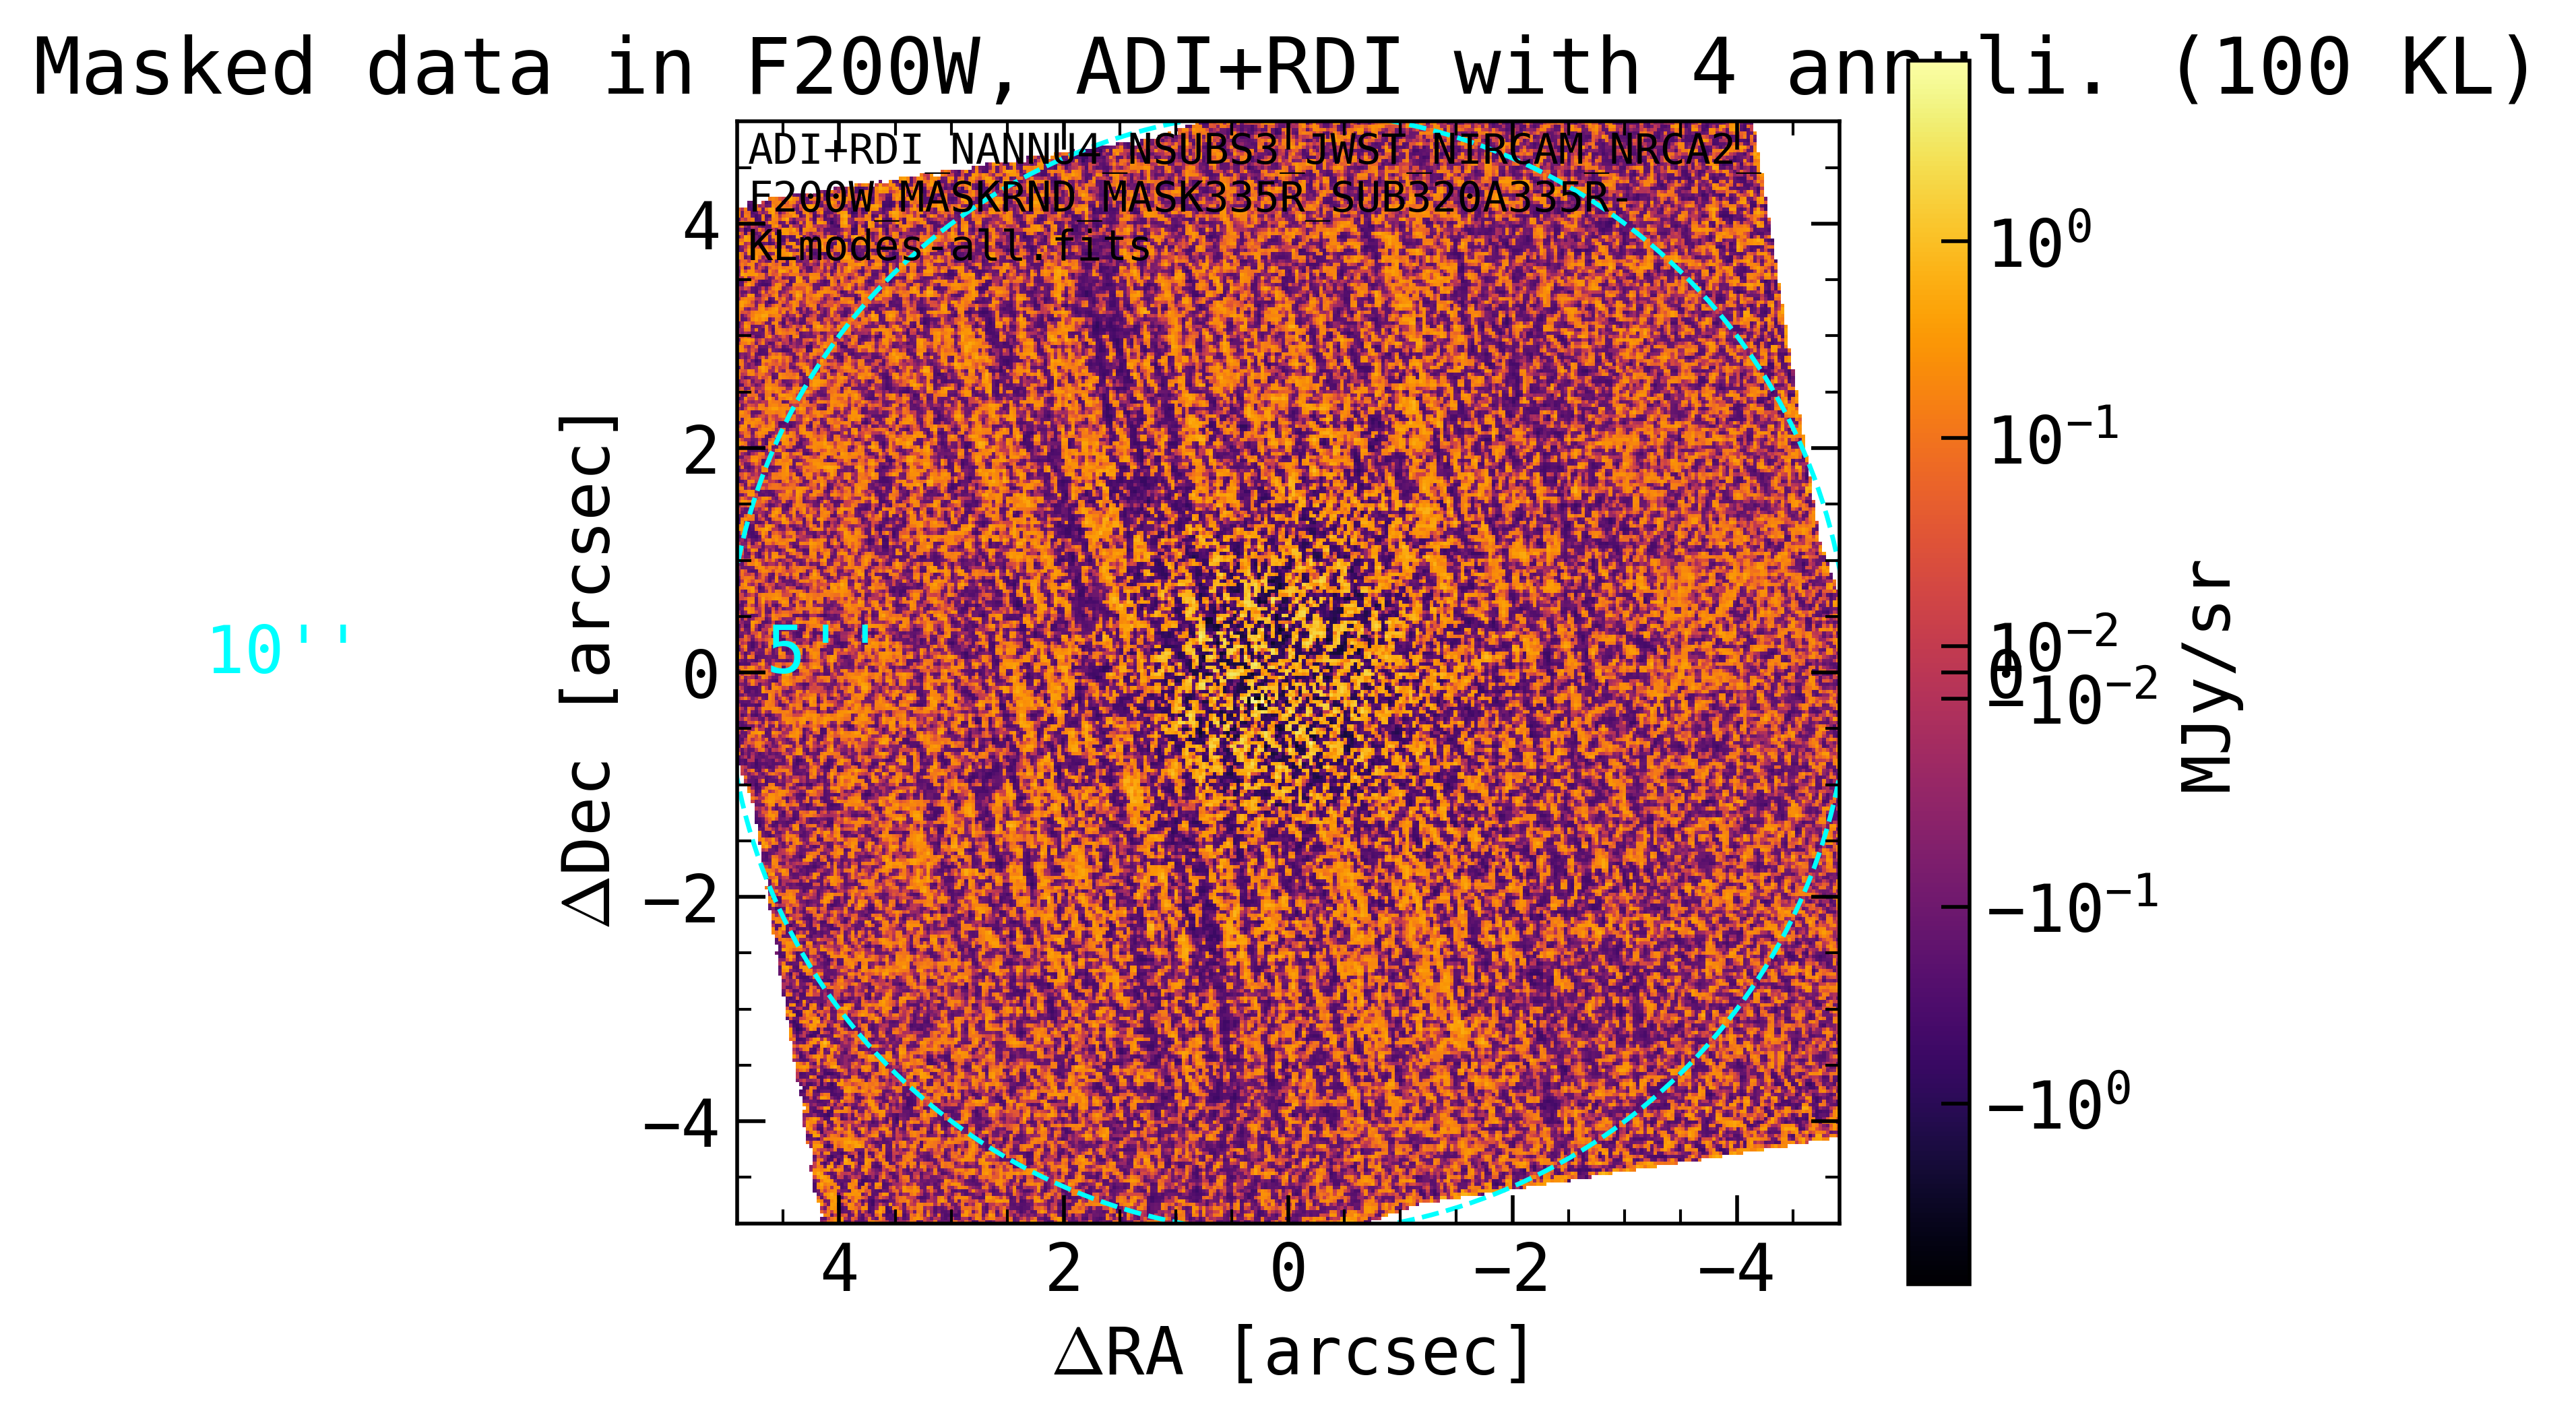

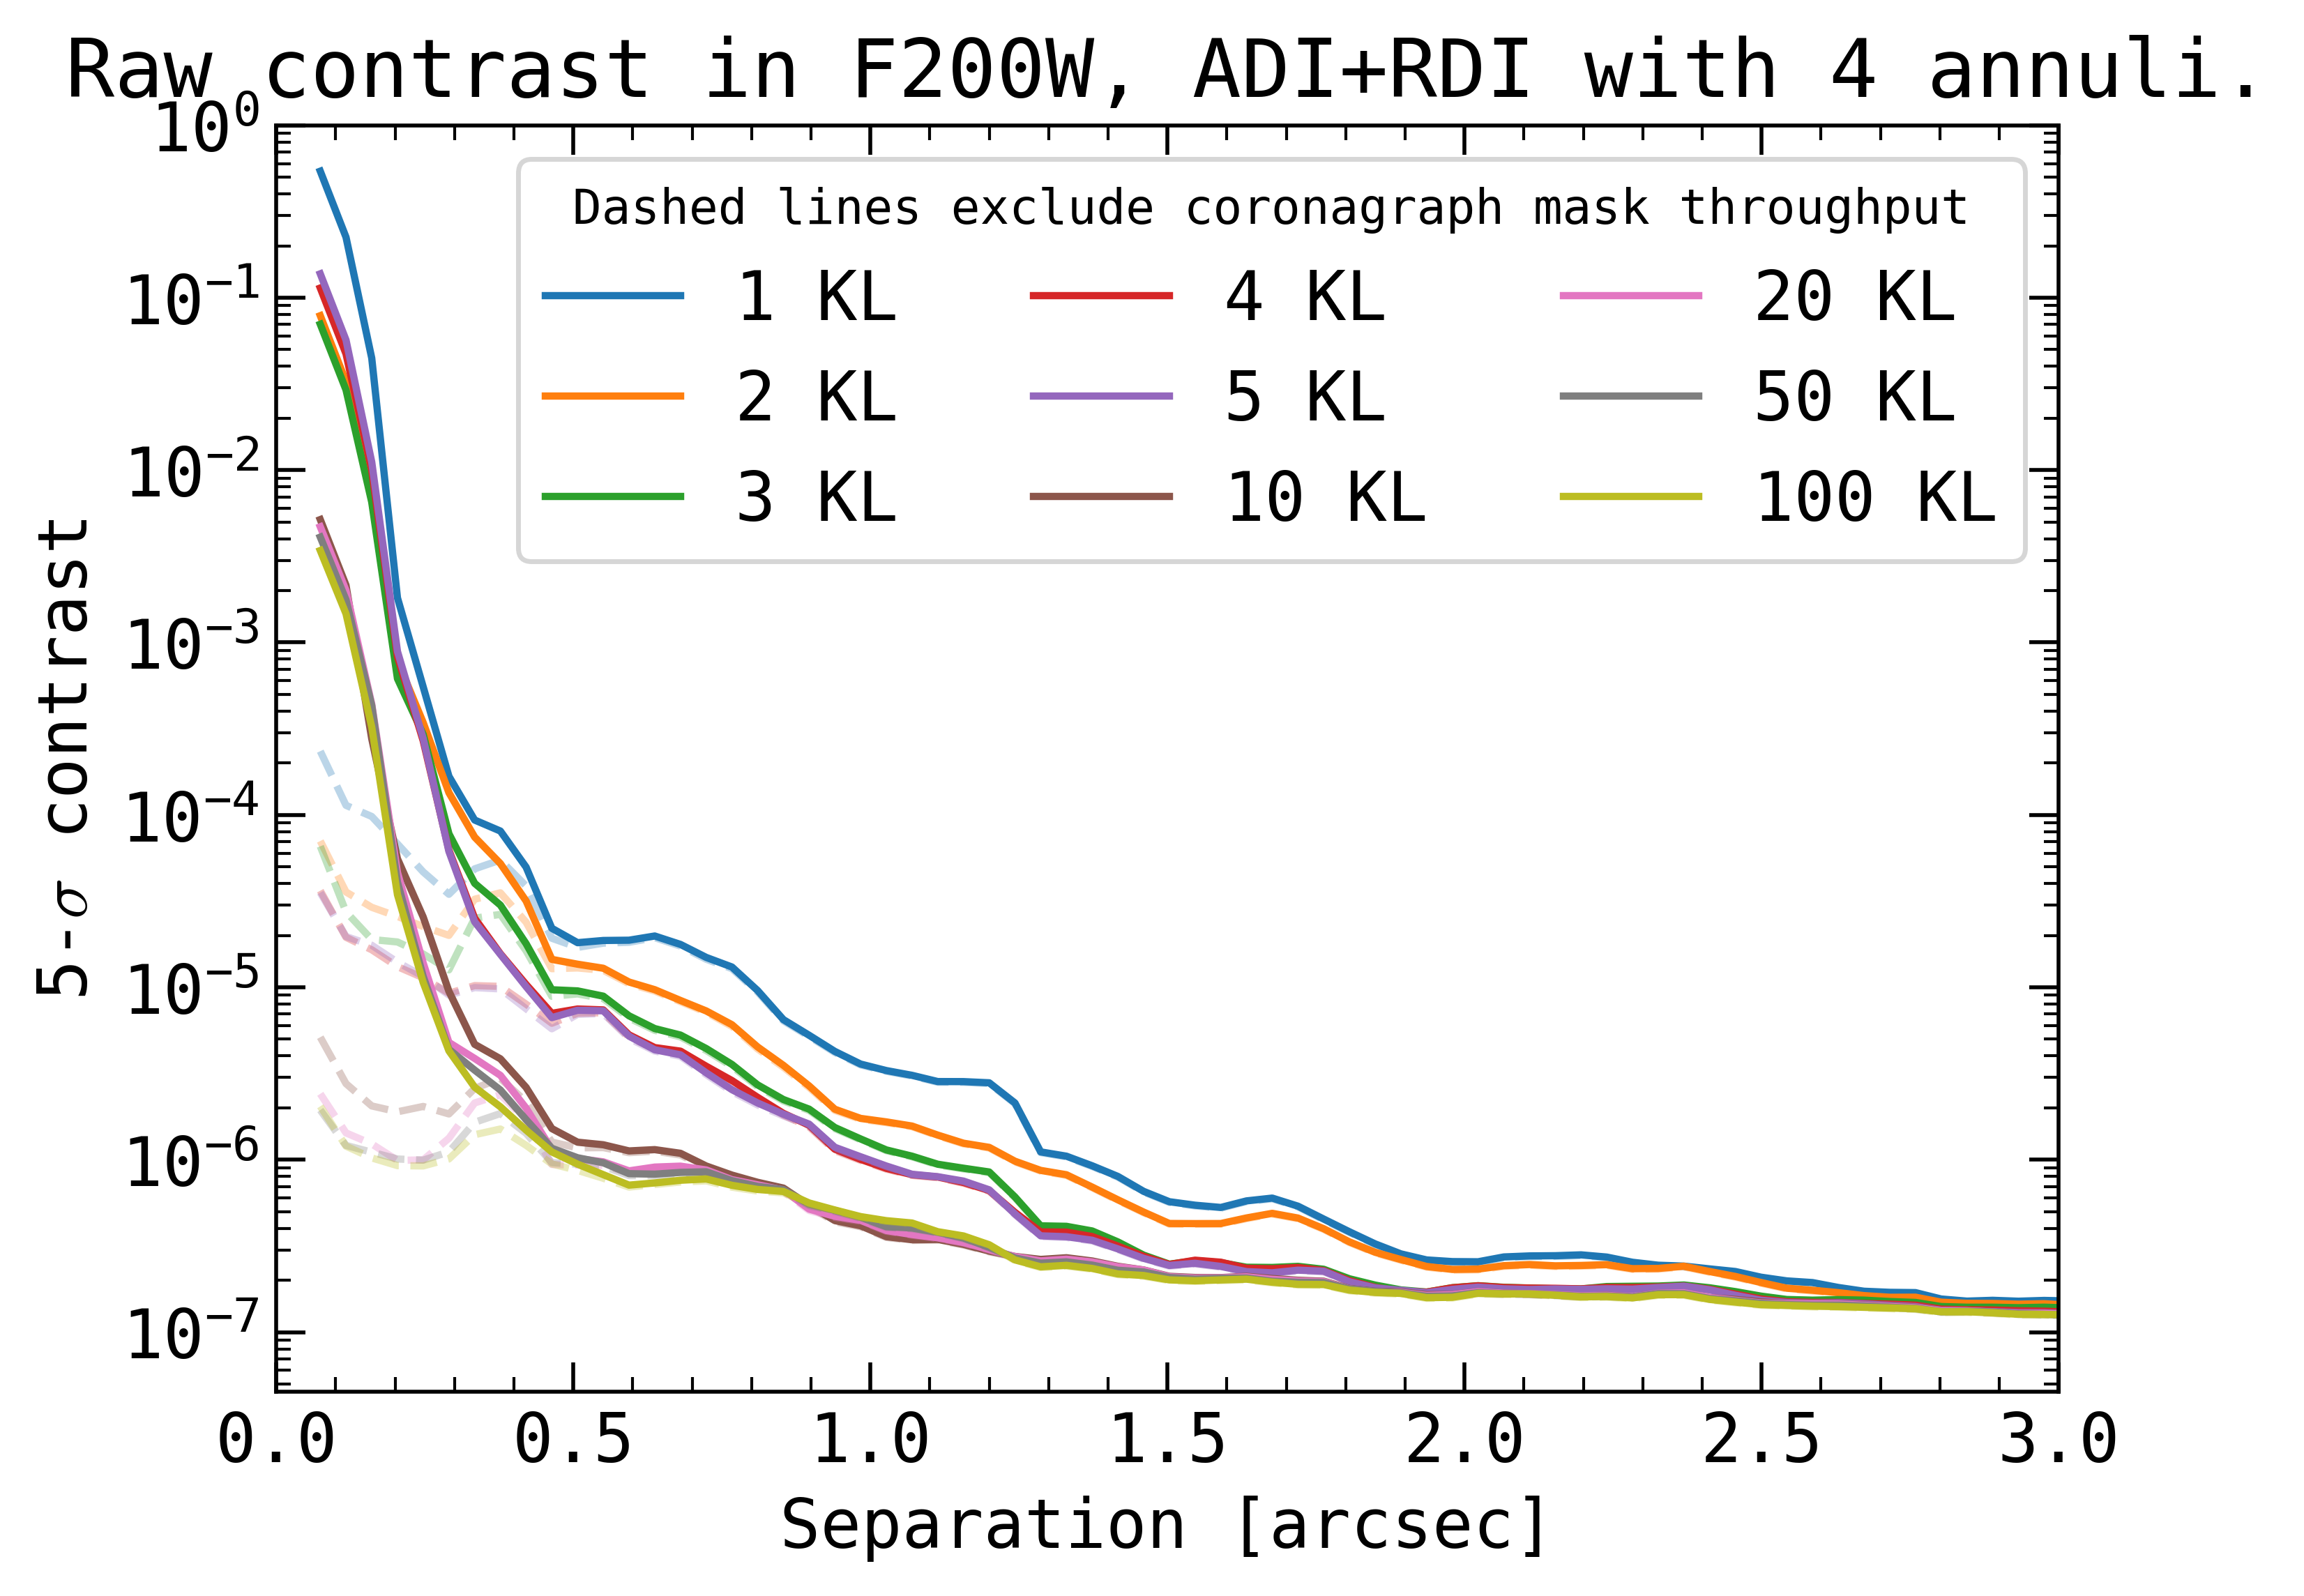

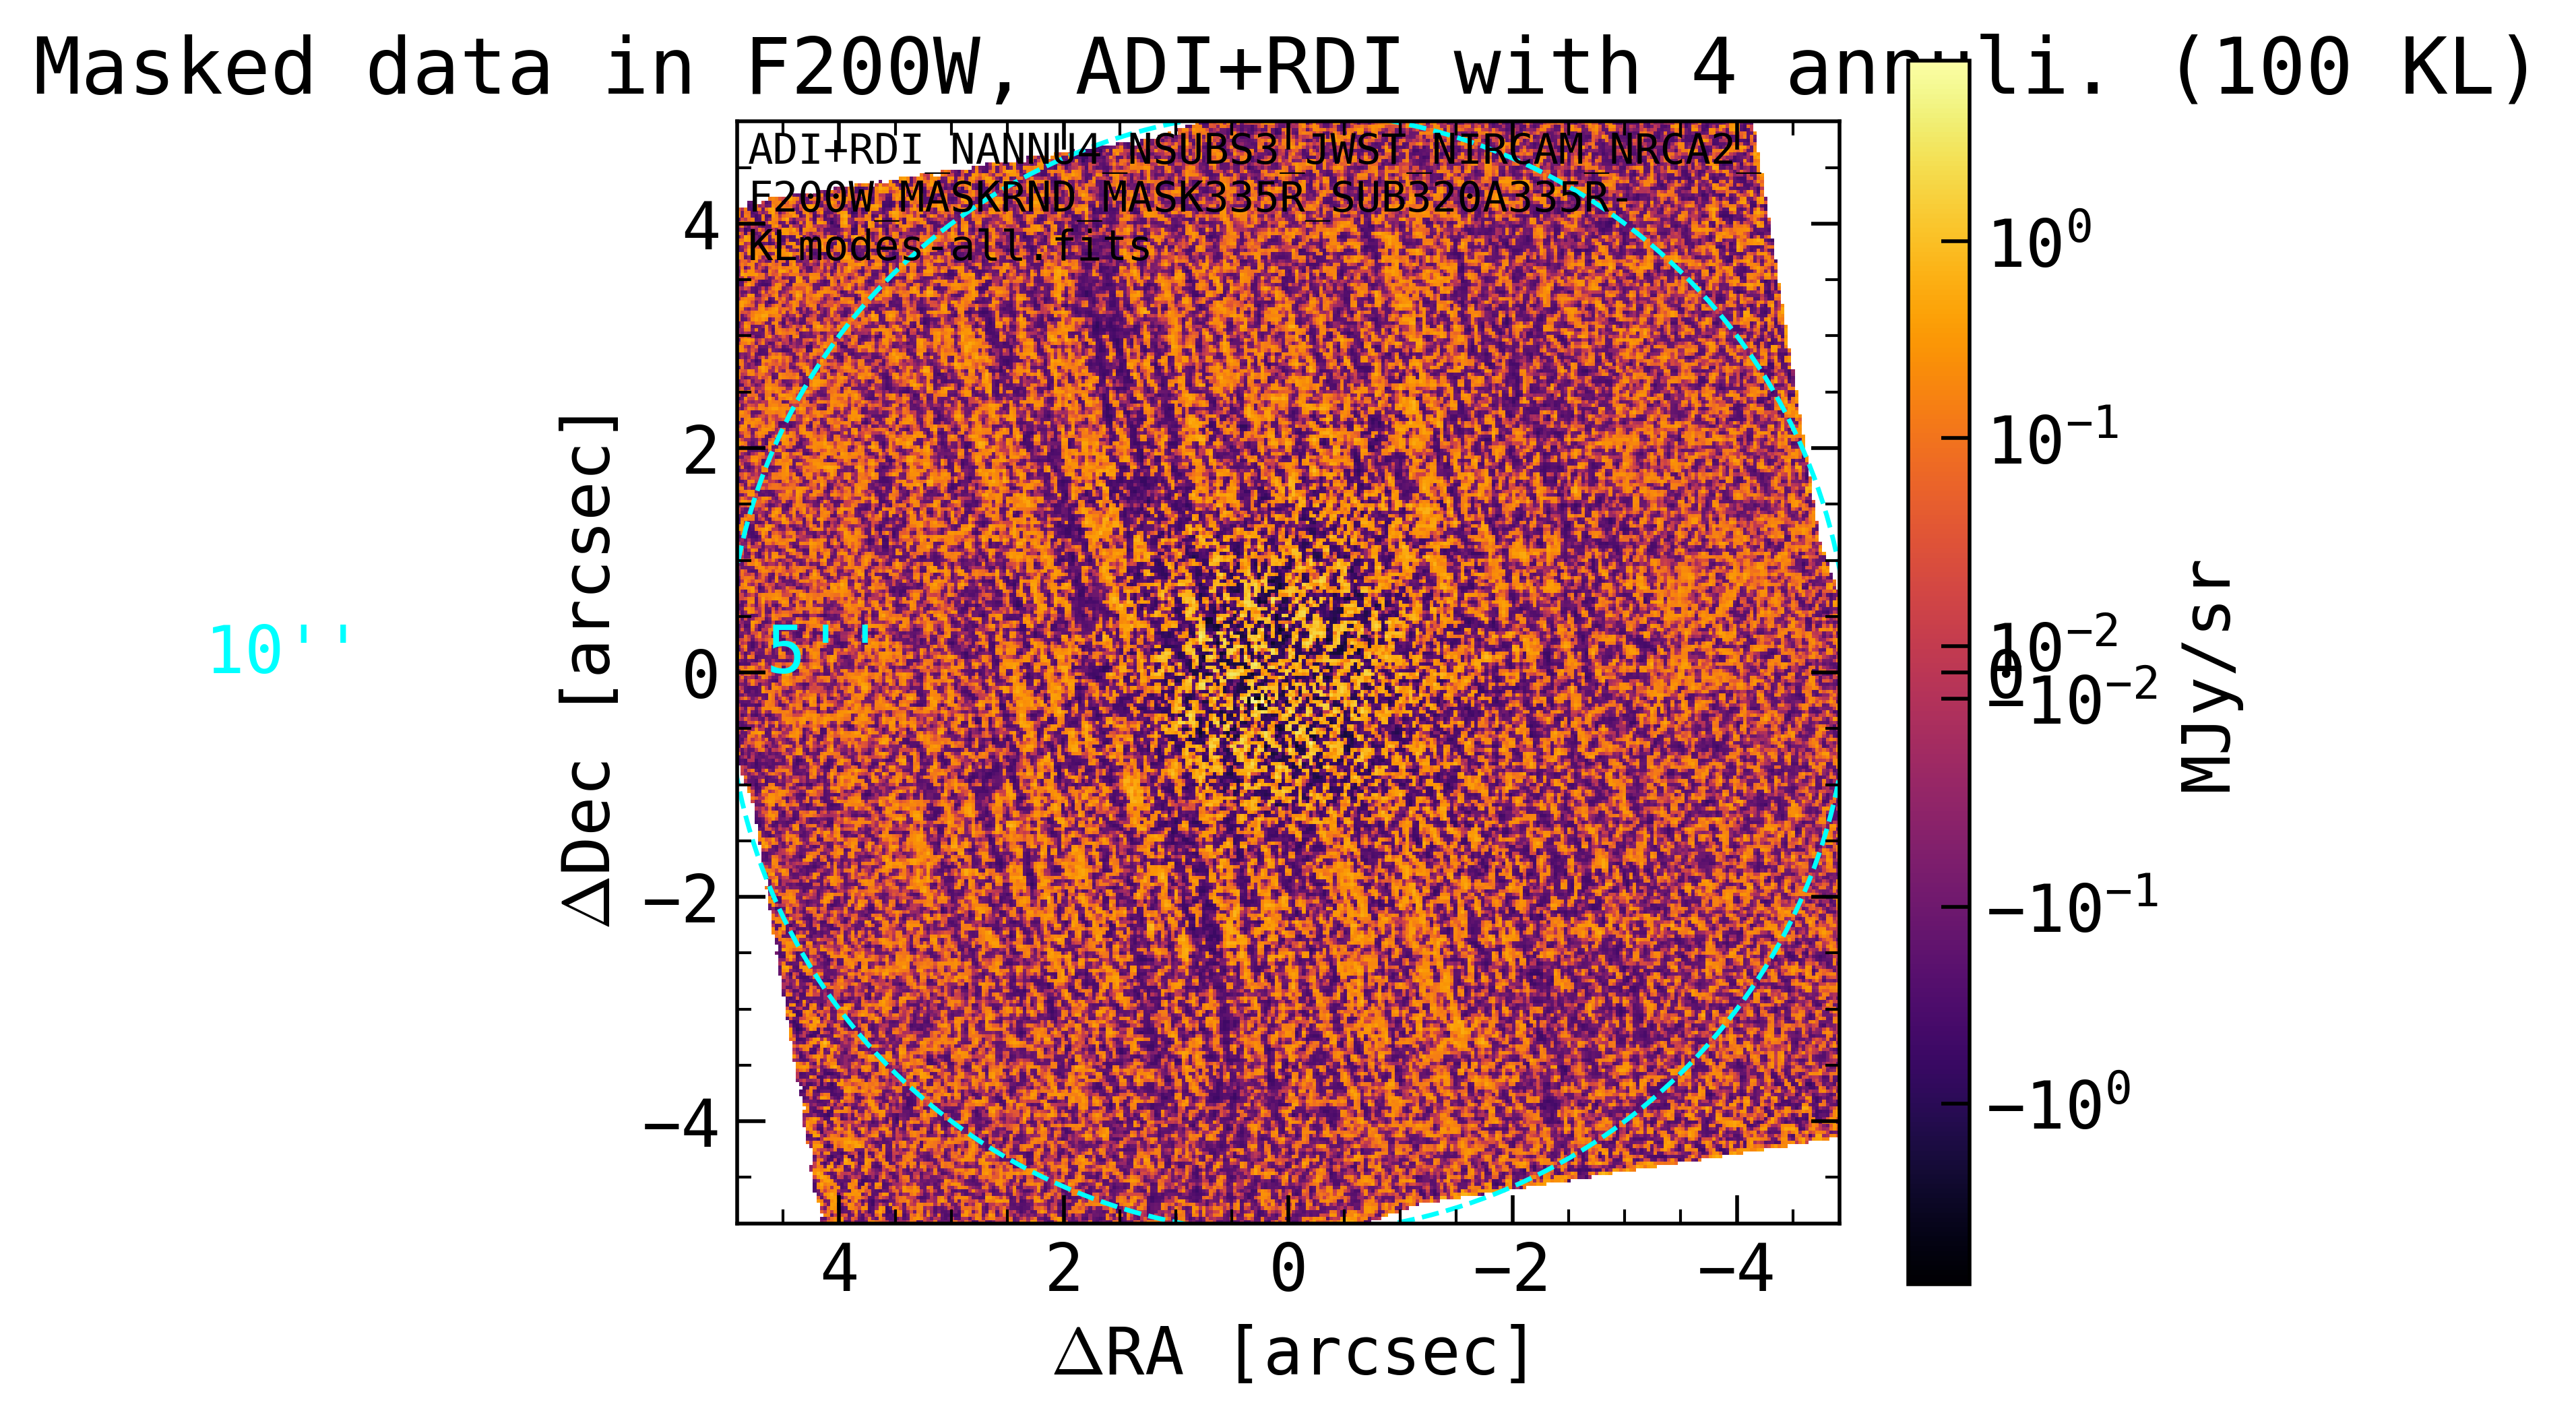

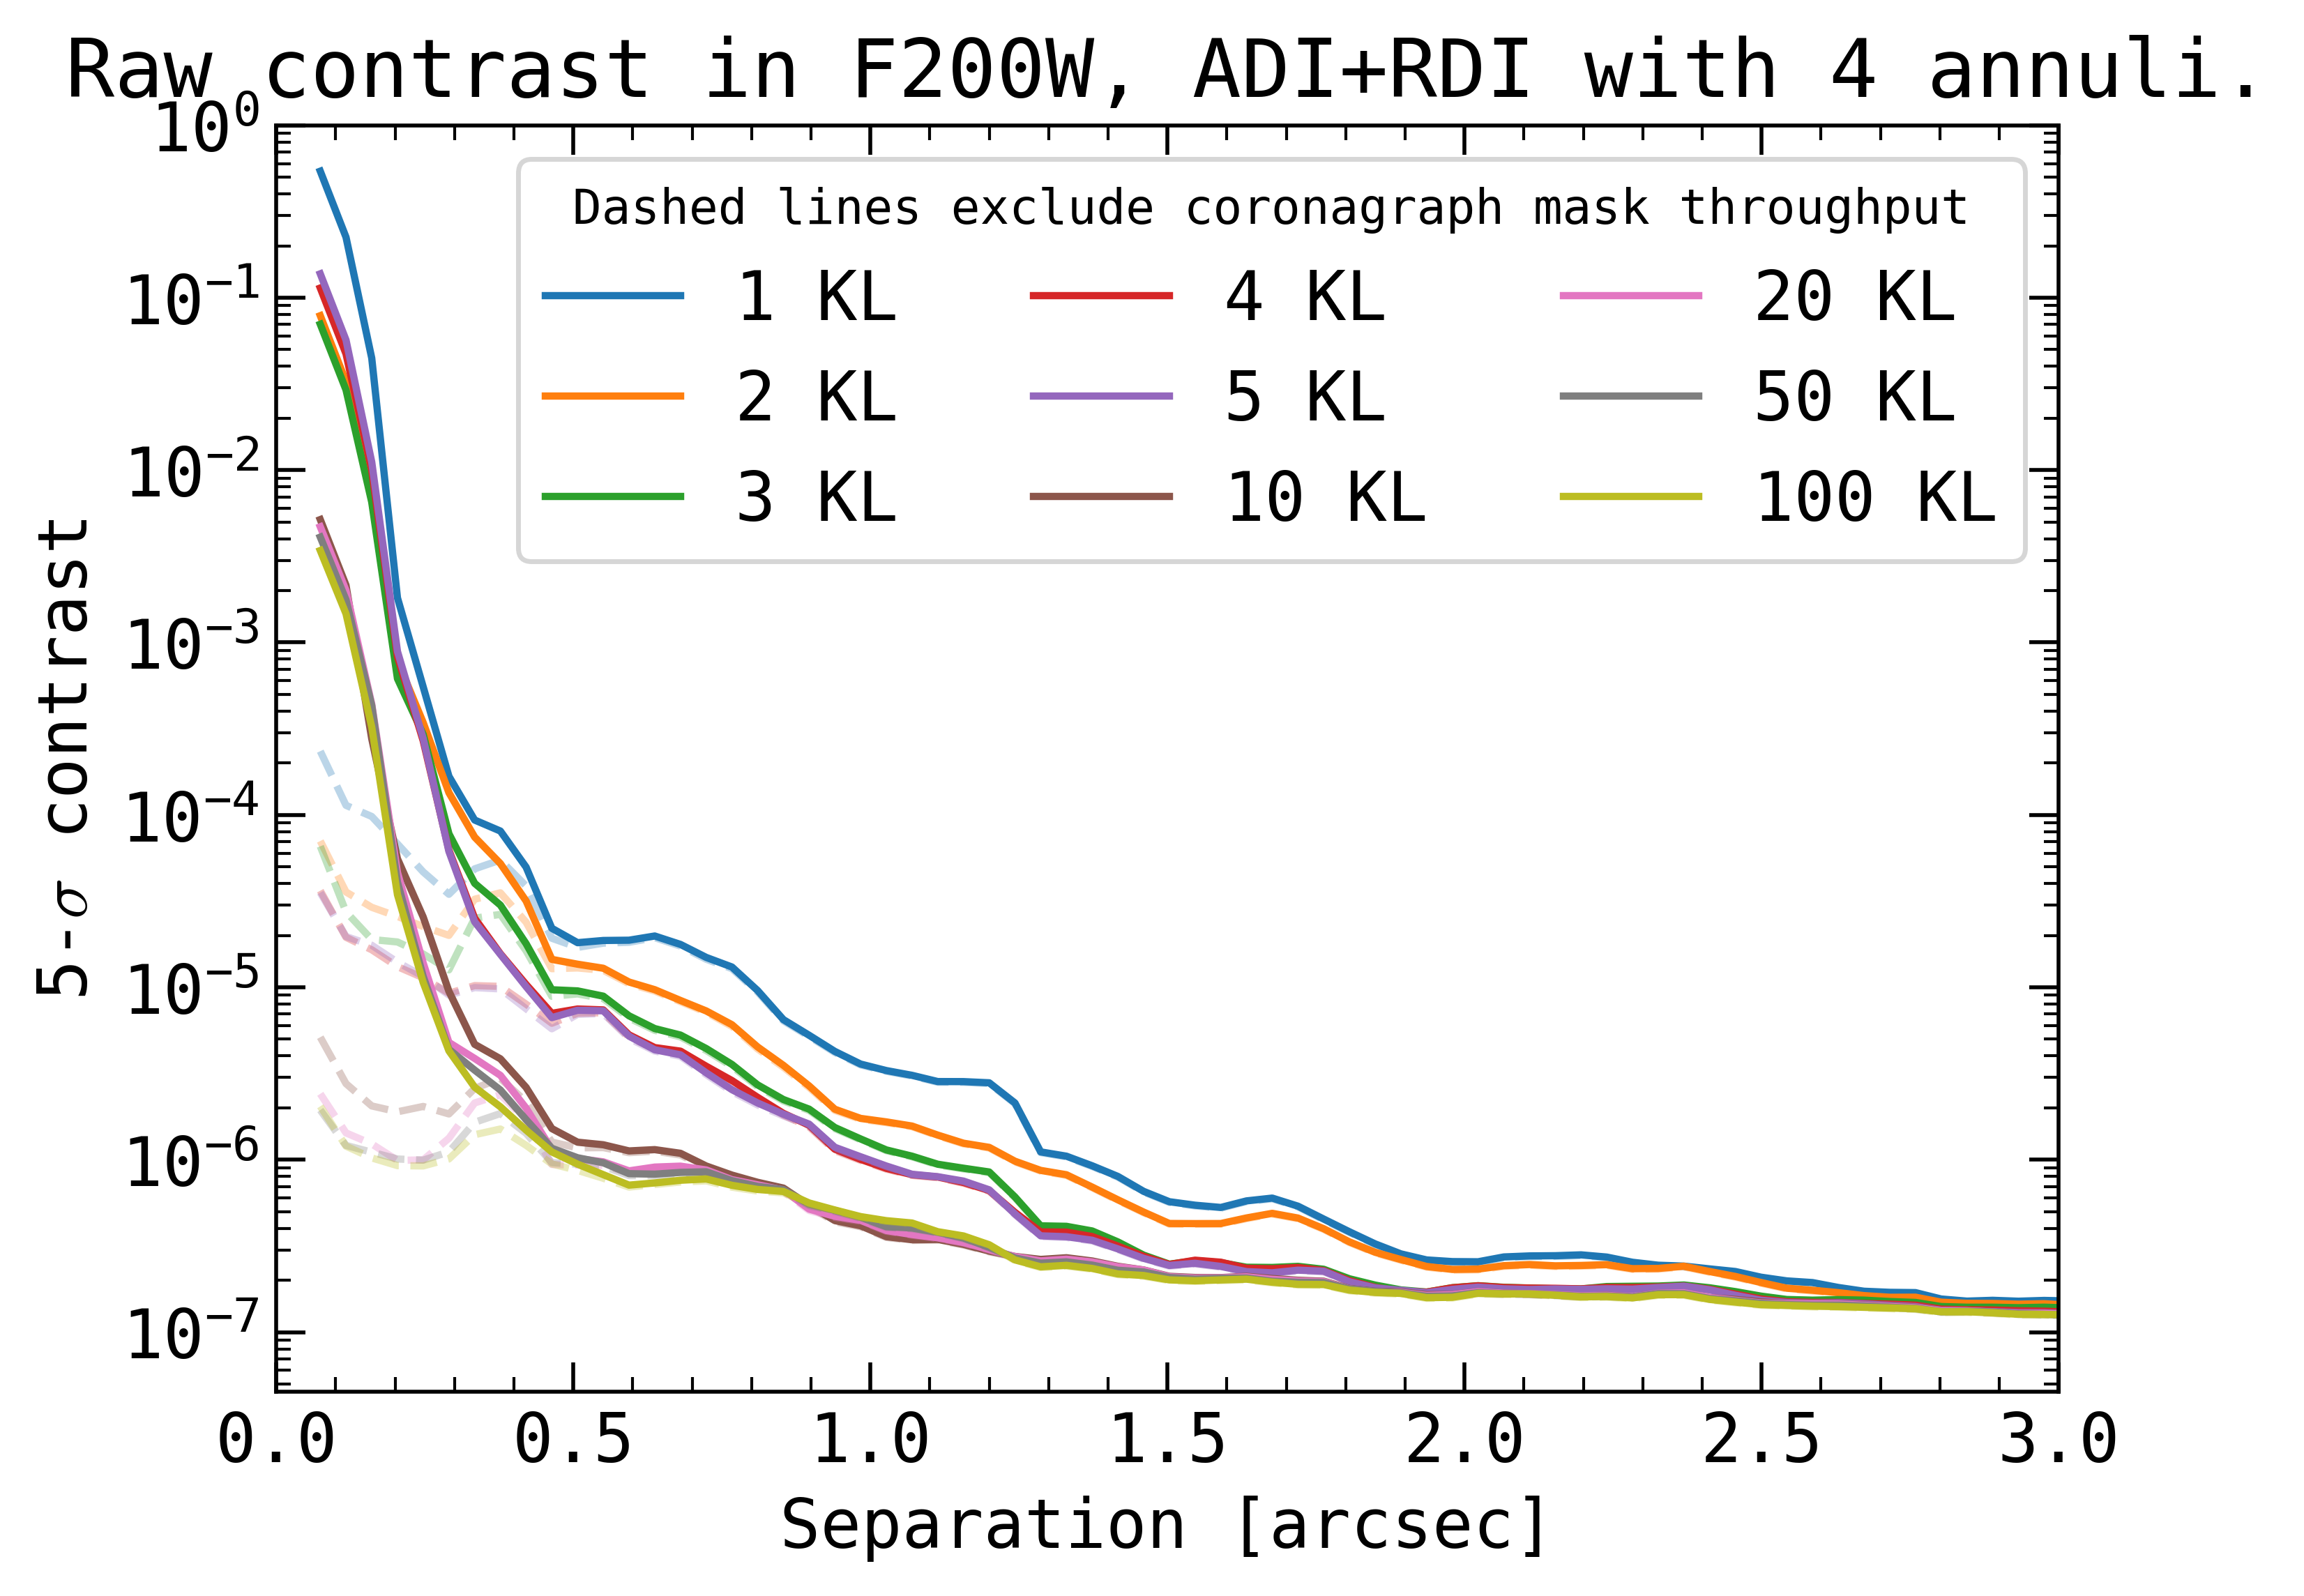

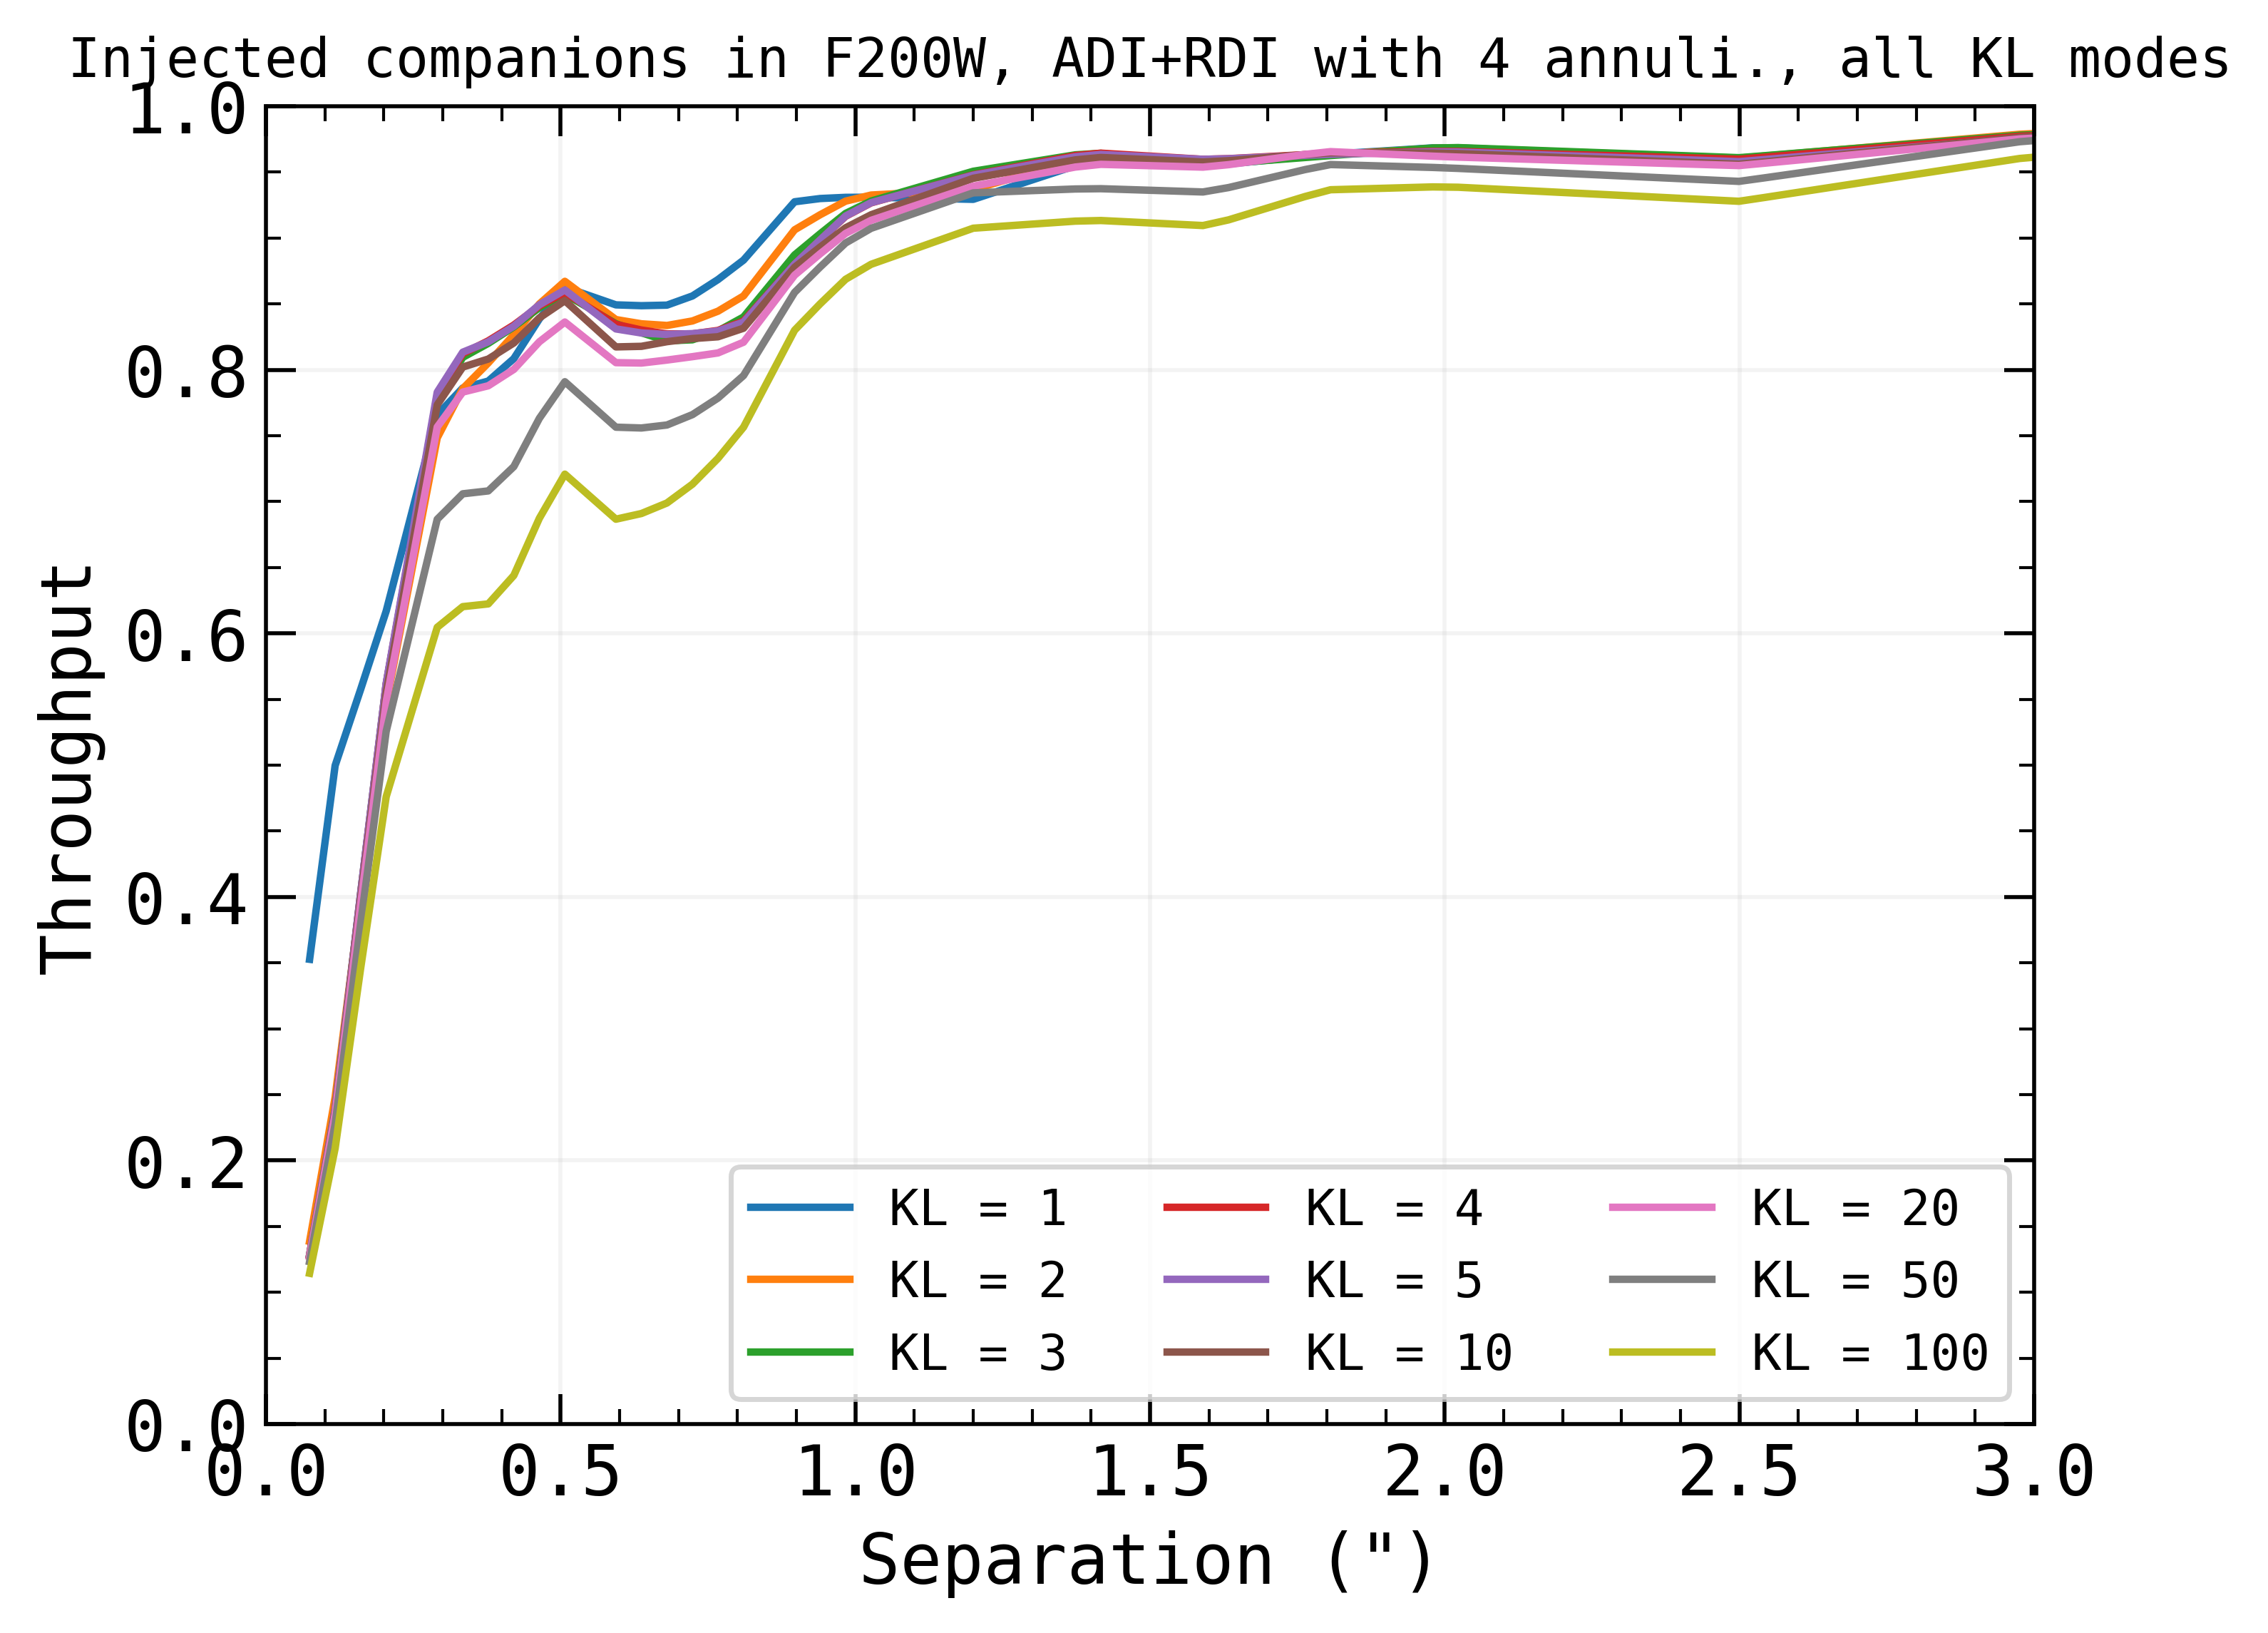

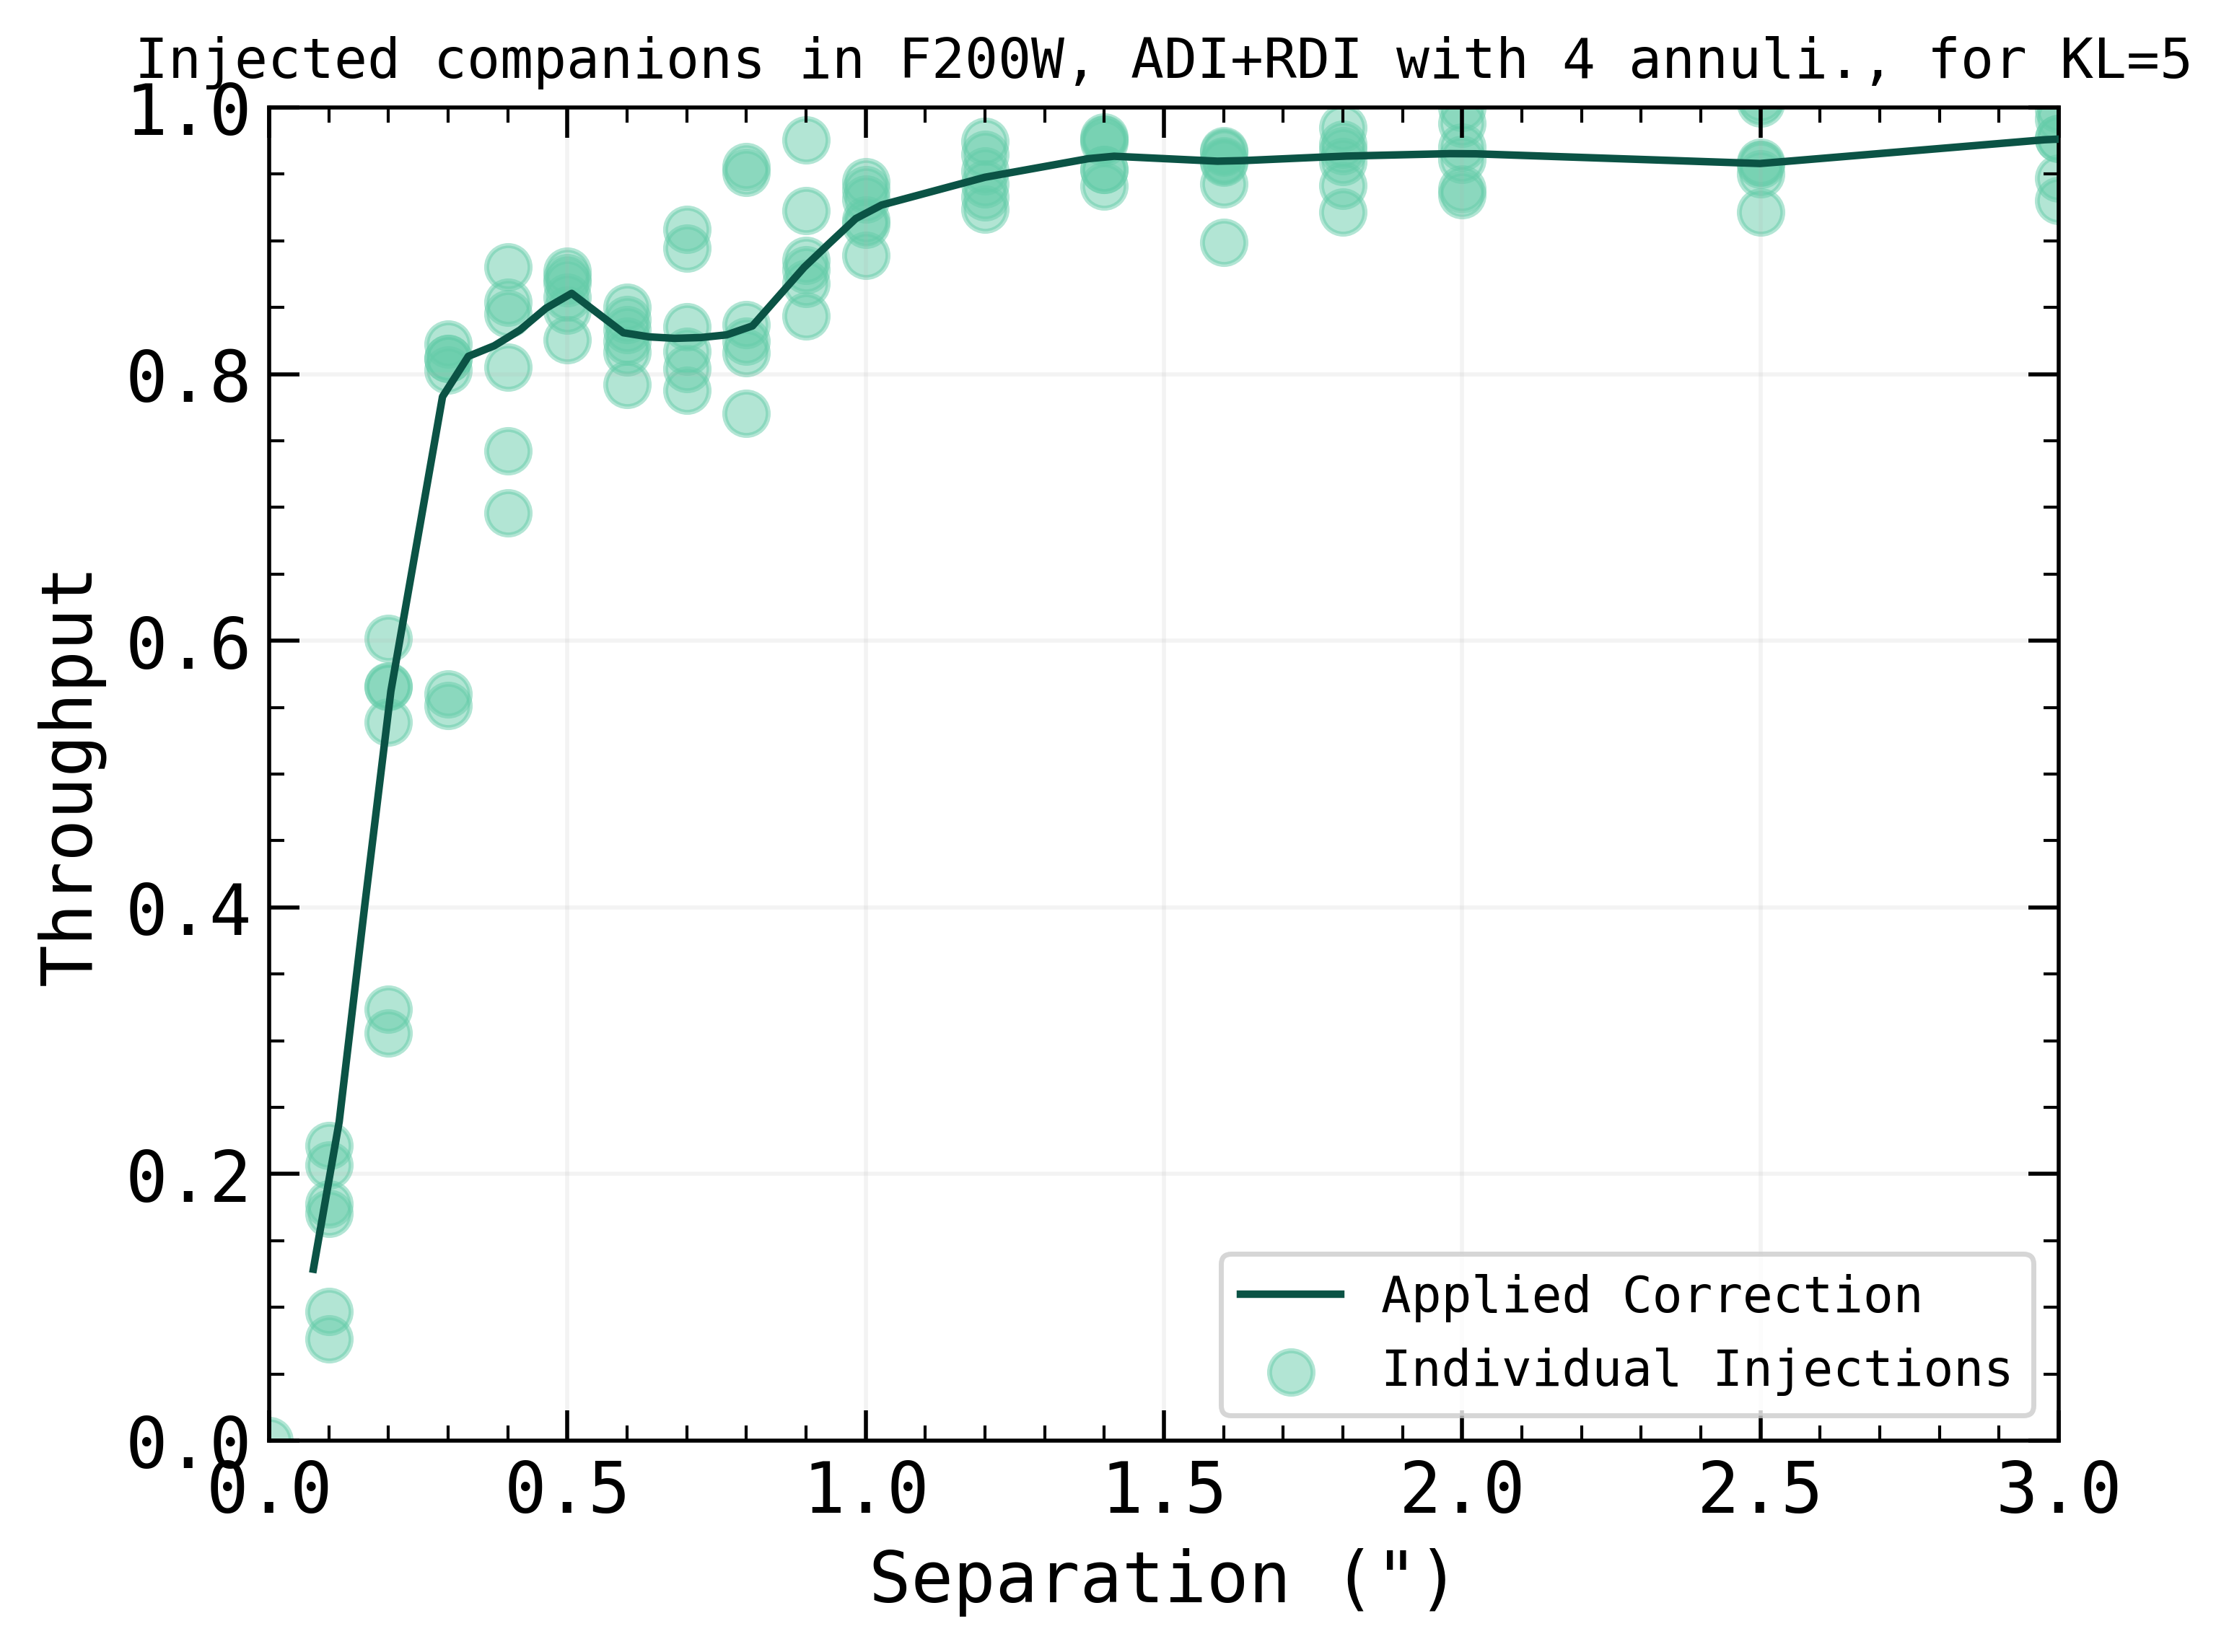

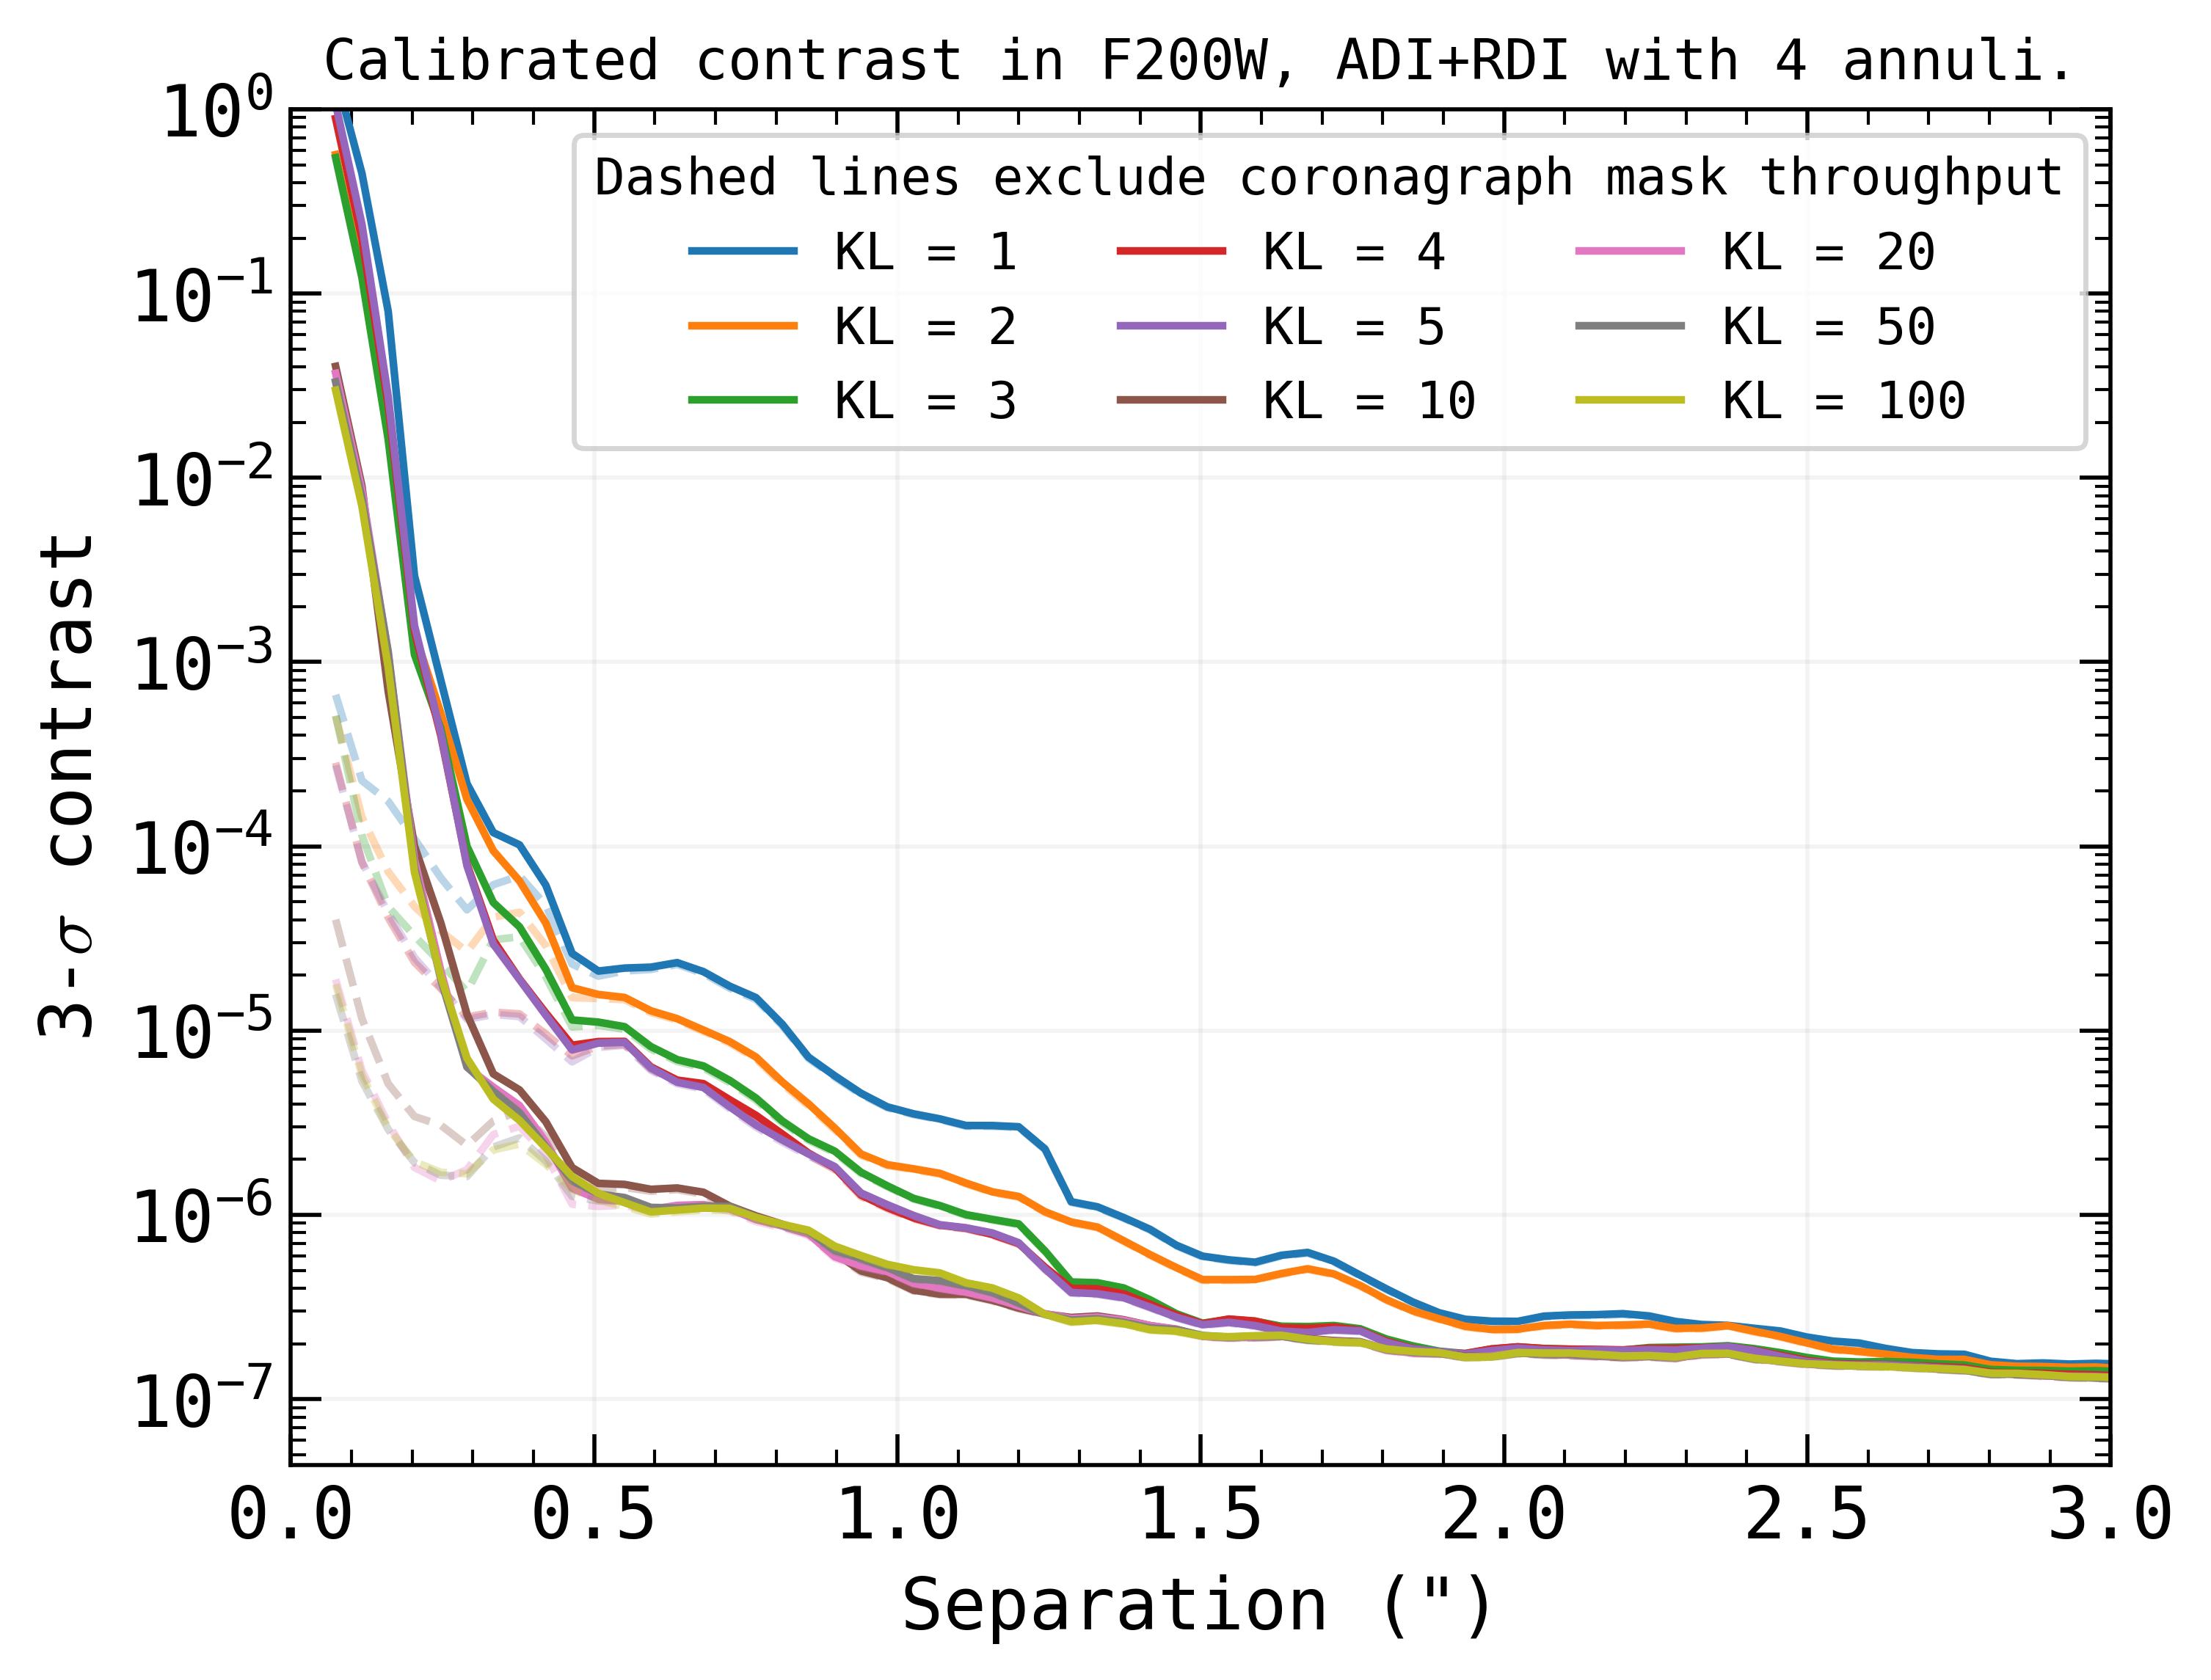

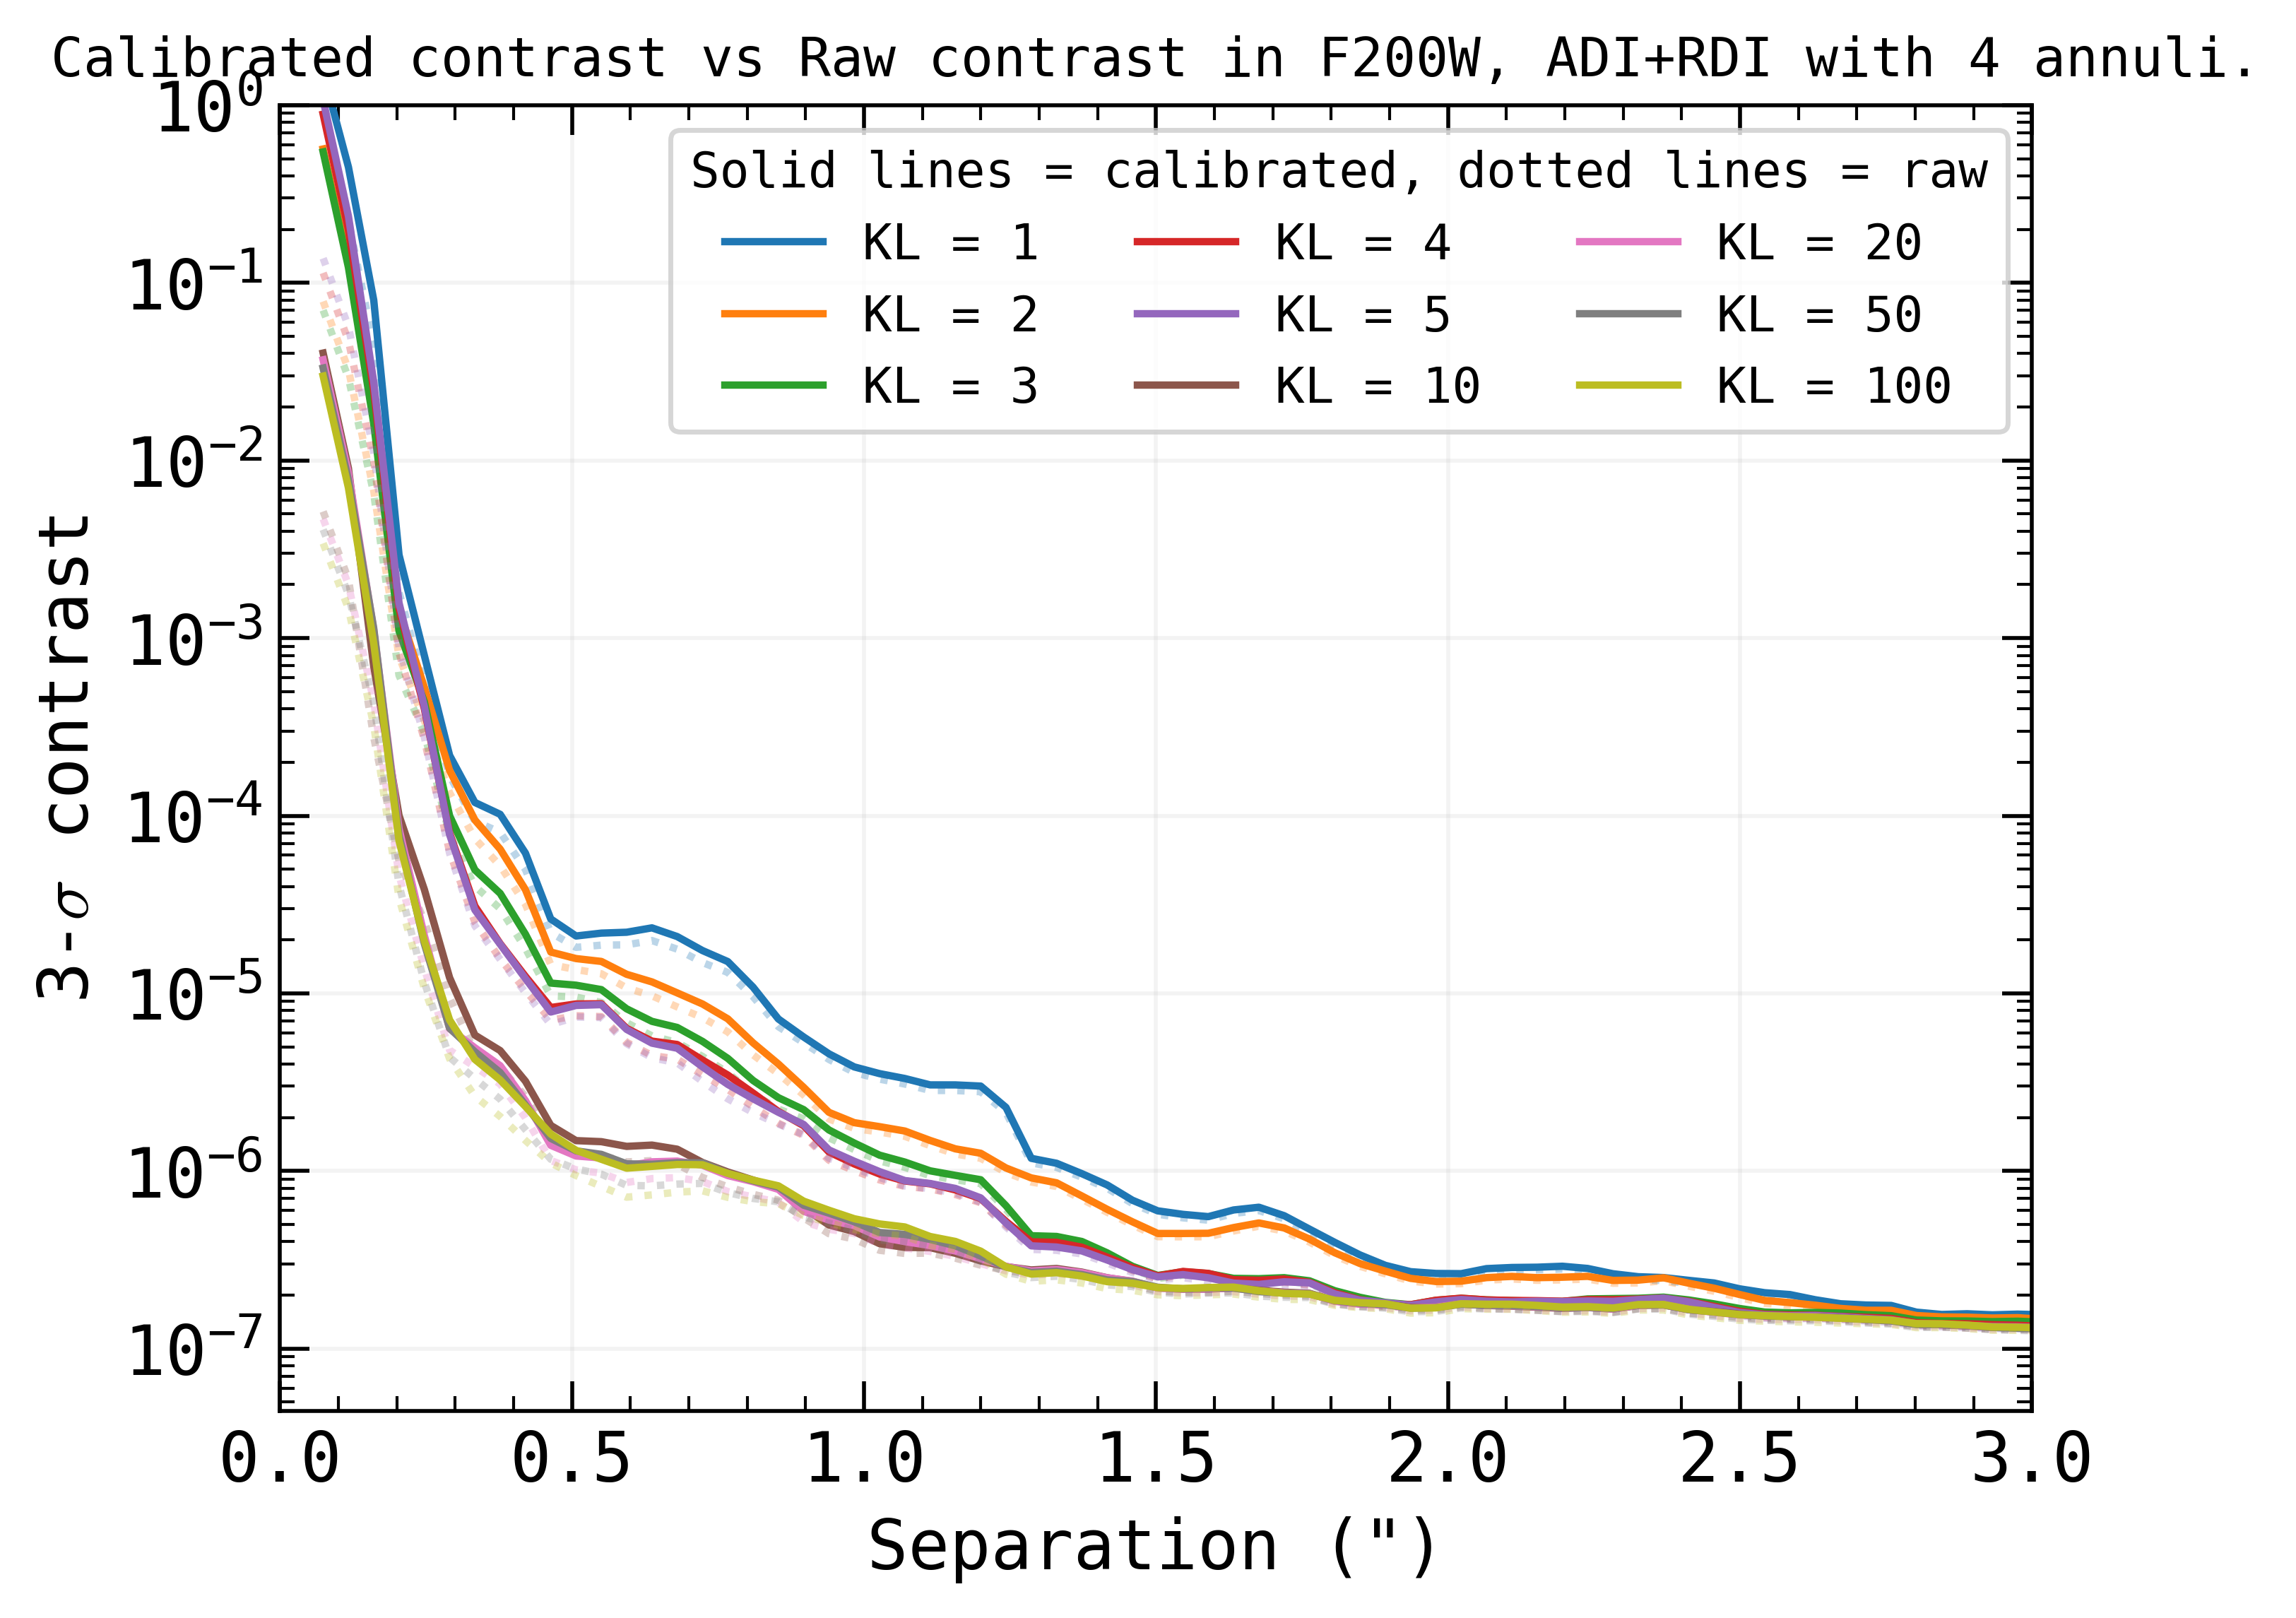

In [32]:
# Set the input and output directories and grab the input FITS files.
reduced = True
cleanalign = True
aligned = True

pad = False
coadd = False
crop = False

if aligned and coadd:
    input_dir = './spaceklip/coadded/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif aligned:
    # input_dir = './spaceklip/aligned/'
    input_dir = './spaceklip/aligned_e1/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif cleanalign:
    input_dir = './spaceklip/nanreplaced/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif reduced:
    input_dir = './spaceklip/stage2/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])
else:
    # input_dir = './04558/'
    # input_dir = './uncal_e1/'
    # input_dir = './uncal_e2/'
    input_dir = './uncal_e3/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

output_dir = './spaceklip/'

# Initialize the spaceKLIP database and read the input FITS files.
Database = database.Database(output_dir=output_dir)
Database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=None,
                             bgpaths=None)

select_obs = [
              'JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R',
              ]

Database.obs = {k:Database.obs[k] for k in select_obs}

ImageTools = imagetools.ImageTools(Database)

pyklippipeline.run_obs(database=Database,
                       kwargs={'mode': ['ADI+RDI'],
                               'annuli': [4],
                               # 'movement': [0.5],
                               'subsections': [3],
                               'numbasis': [1, 2, 3, 4, 5, 10, 20, 50, 100],
                               'algo': 'klip'},
                       subdir='klipsub_e1')

Analysis = analysistools.AnalysisTools(Database)

companions = [[.3173, .0663, 1e-4]]
# companions = [[.3147, .0531, 1e-4]]

# blob 119.3 and 240.2 pixels
# cen = 320//2
# companions = [[(cen-119.3)*0.063, (240.2-cen)*0.063, 1e-6]]

starfile = './AFLepA.vot'

mstar_err = 0.0
# {'F200W':0.002773909429007033, 
#              'F356W':0.0302418599954501, 
#              'F444W':0.037934753620330594}

# Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon_e1')

# inj_seps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
# Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon')
# Analysis.calibrate_contrast(
#                             companions=companions,
#                             injection_seps=inj_seps,
#                             plot_xlim=(0,3),
#                             subdir='calcon_e1'
#                            )

Analysis.extract_companions(companions, 
                            starfile, 
                            mstar_err, 
                            klmode=100,
                            spectral_type='F8V', 
                            fitmethod='nested',
                            fitkernel='diag',
                            subdir='companions_e1'
                           )

In [ ]:
# Set the input and output directories and grab the input FITS files.
reduced = True
cleanalign = True
aligned = True

pad = False
coadd = False
crop = False

if aligned and coadd:
    input_dir = './spaceklip/coadded/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif aligned:
    # input_dir = './spaceklip/aligned/'
    input_dir = './spaceklip/aligned_e3/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif cleanalign:
    input_dir = './spaceklip/nanreplaced/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('calints.fits')])
elif reduced:
    input_dir = './spaceklip/stage2/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])
else:
    # input_dir = './04558/'
    # input_dir = './uncal_e1/'
    # input_dir = './uncal_e2/'
    input_dir = './uncal_e3/'
    fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

output_dir = './spaceklip/'

# Initialize the spaceKLIP database and read the input FITS files.
Database = database.Database(output_dir=output_dir)
Database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=None,
                             bgpaths=None)

select_obs = [
              'JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R',
              ]

Database.obs = {k:Database.obs[k] for k in select_obs}

ImageTools = imagetools.ImageTools(Database)

pyklippipeline.run_obs(database=Database,
                       kwargs={'mode': ['ADI+RDI'],
                               'annuli': [4],
                               # 'movement': [0.5],
                               'subsections': [3],
                               'numbasis': [1, 2, 3, 4, 5, 10, 20, 50, 100],
                               'algo': 'klip'},
                       subdir='klipsub_e3')

Analysis = analysistools.AnalysisTools(Database)

# companions = [[.3173, .0663, 1e-4]]
companions = [[.3147, .0531, 1e-4]]

# blob 119.3 and 240.2 pixels
# cen = 320//2
# companions = [[(cen-119.3)*0.063, (240.2-cen)*0.063, 1e-6]]

starfile = './AFLepA.vot'

mstar_err = 0.0
# {'F200W':0.002773909429007033, 
#              'F356W':0.0302418599954501, 
#              'F444W':0.037934753620330594}

Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon_e3')

inj_seps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
Analysis.raw_contrast(starfile,spectral_type='F8V',companions=companions, plot_xlim=(0,3), subdir='rawcon')
Analysis.calibrate_contrast(
                            companions=companions,
                            injection_seps=inj_seps,
                            plot_xlim=(0,3),
                            subdir='calcon_e3'
                           )

# Analysis.extract_companions(companions, 
#                             starfile, 
#                             mstar_err, 
#                             klmode=100,
#                             spectral_type='F8V', 
#                             fitmethod='mcmc',
#                             fitkernel='diag',
#                             subdir='companions_e3'
#                            )